# **Indicadores de Portafolios**

Autor: Sergio Diaz Paredes

Contacto: [Linkedin](https://www.linkedin.com/in/sergio-diaz-paredes/)

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.optimize import minimize

## Importando Datos

In [2]:
empresas = ['MSFT', 'KO']
datos = yf.download(empresas, start='2021-01-01', end='2023-06-30')
datos = datos['Adj Close']
datos.head()

[*********************100%***********************]  2 of 2 completed


Ticker,KO,MSFT
Date,,
2021-01-04,47.085602,210.844284
2021-01-05,46.567989,211.047699
2021-01-06,45.086525,205.575378
2021-01-07,44.586758,211.425430
2021-01-08,45.586288,212.713593


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

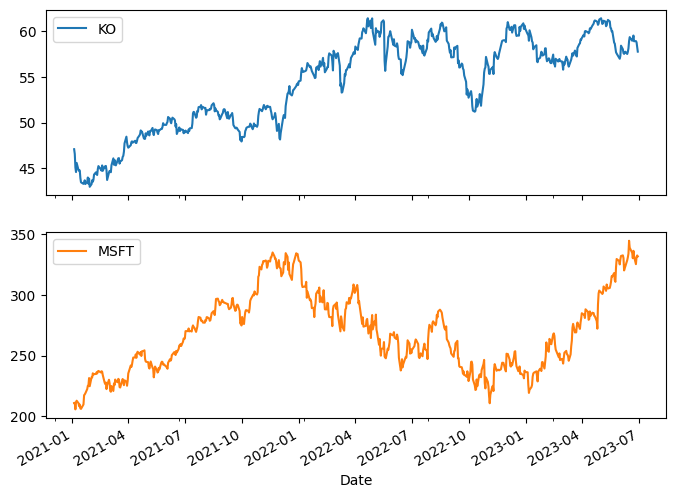

In [3]:
datos.plot(figsize=(8,6), subplots=True)

## Calculos iniciales

Antes de trabajar en los indicadores, debemos realizar los siguientes cálculos base:

### **Rendimientos diarios** ($R_i$):

   Usaremos los precios ajustados para calcular los retornos diarios:
   $$
   R_t = \frac{P_t}{P_{t-1}} - 1
   $$

In [4]:
datos.pct_change().head()

Ticker,KO,MSFT
Date,,
2021-01-04,NaN,NaN
2021-01-05,-0.010993,0.000965
2021-01-06,-0.031813,-0.025929
2021-01-07,-0.011085,0.028457
2021-01-08,0.022418,0.006093


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

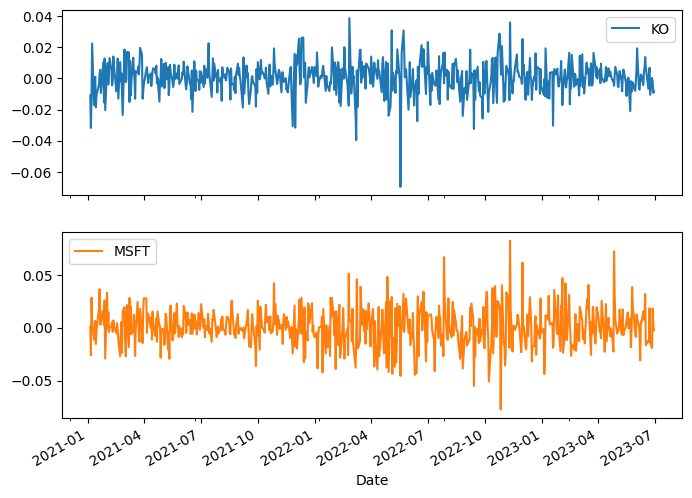

In [5]:
datos.pct_change().plot(figsize=(8,6),subplots=True)

### **Rendimiento promedio anualizado** ($\mu$):

   Ajustaremos los retornos diarios para obtener el promedio anualizado:
   $$
   \mu = (1 + \bar{R}_{diario})^{252} - 1
   $$
   (considerando 252 días hábiles al año).

In [6]:
# Calcular los retornos diarios
retornos_diarios = datos.pct_change()

# Calcular el rendimiento anualizado
rendimiento_anualizado = (1 + retornos_diarios.mean())**252 - 1

# Mostrar los resultados
print("Rendimiento anualizado:")
print(rendimiento_anualizado)

Rendimiento anualizado:
Ticker
KO      0.100859
MSFT    0.252046
dtype: float64


### **Volatilidad anualizada ($\sigma$)**:

   Calcularemos la desviación estándar de los retornos diarios y la escalaremos:
   $$
   \sigma = \text{std}(R_{diario}) \cdot \sqrt{252}
   $$

In [7]:
# Calcular la volatilidad anualizada
volatilidad_anualizada = retornos_diarios.std() * (252**0.5)

print("\nVolatilidad anualizada:")
print(volatilidad_anualizada)


Volatilidad anualizada:
Ticker
KO      0.165353
MSFT    0.290066
dtype: float64


## Proceso de optimización

El proceso operativo de programación para optimizar un portafolio implica los siguientes pasos:

1. **Definir entradas**:
   - **Rendimientos esperados**: Los retornos promedio históricos de cada activo.
   - **Matriz de covarianzas**: Relación entre la volatilidad y los retornos de los activos.
   - **Tasa libre de riesgo**: Generalmente una tasa anual de referencia (por ejemplo, 0.033).

2. **Función objetivo**:
   Cada indicador (Sharpe, Sortino, varianza mínima, etc.) tendrá su propia función objetivo. Esta es la fórmula que optimizamos, ya sea maximizando o minimizando según el caso:
   - Para el **Ratio de Sharpe**, buscamos maximizar el cociente entre el rendimiento ajustado por riesgo y la volatilidad.
   - Para **Varianza mínima**, minimizamos el riesgo del portafolio calculando su varianza.

3. **Restricciones**:
   - La restricción básica es que los pesos sumen 1, es decir, $\sum w_i = 1$.
   - Si no permitimos posiciones cortas, también agregamos la restricción de que cada peso debe ser mayor o igual a 0.

4. **Optimización**:
   Usamos la función `minimize` de `scipy.optimize` para encontrar los pesos óptimos que cumplen con la función objetivo y las restricciones.

5. **Resultados**:
   Una vez resuelto el problema, los pesos óptimos nos indican cómo asignar el capital en cada activo.

## Frontera eficiente

La **frontera eficiente** es un concepto fundamental en la teoría moderna de portafolios, desarrollada por Harry Markowitz. Representa el conjunto de portafolios óptimos que ofrecen el máximo rendimiento esperado para un nivel dado de riesgo (volatilidad), o el mínimo riesgo para un rendimiento esperado específico.

En otras palabras, la frontera eficiente muestra las combinaciones de activos que optimizan la relación riesgo-rendimiento, donde ningún portafolio dentro de la frontera puede mejorar su rendimiento sin aumentar su riesgo, ni reducir su riesgo sin sacrificar rendimiento.

Matemáticamente, se construye a partir de los rendimientos esperados y las covarianzas entre los activos del portafolio, ayudando a los inversionistas a tomar decisiones informadas sobre cómo asignar sus inversiones para maximizar la eficiencia de su portafolio.

In [8]:
# Calcular la matriz de covarianzas de los activos
covarianzas = retornos_diarios.cov()
covarianzas_diarias = retornos_diarios.cov()
rendimiento_anualizado = retornos_diarios.mean() * 252
covarianzas_anualizada = covarianzas_diarias * 252

In [9]:
# Graficar la relación entre rendimiento y riesgo para el portafolio
n_puntos = 100  # Número de puntos a simular
rendimientos = []
riesgos = []

# Generar la combinación de los dos activos
for i in range(n_puntos):
    # Generamos pesos de los activos (la suma debe ser 1)
    w_1 = i / (n_puntos - 1)
    w_2 = 1 - w_1
    pesos = np.array([w_1, w_2])

    # Rendimiento esperado
    rendimiento = np.dot(pesos, rendimiento_anualizado)

    # Riesgo (volatilidad)
    riesgo = np.sqrt(np.dot(pesos.T, np.dot(covarianzas_anualizada, pesos)))

    # Almacenar los resultados
    riesgos.append(riesgo)
    rendimientos.append(rendimiento)

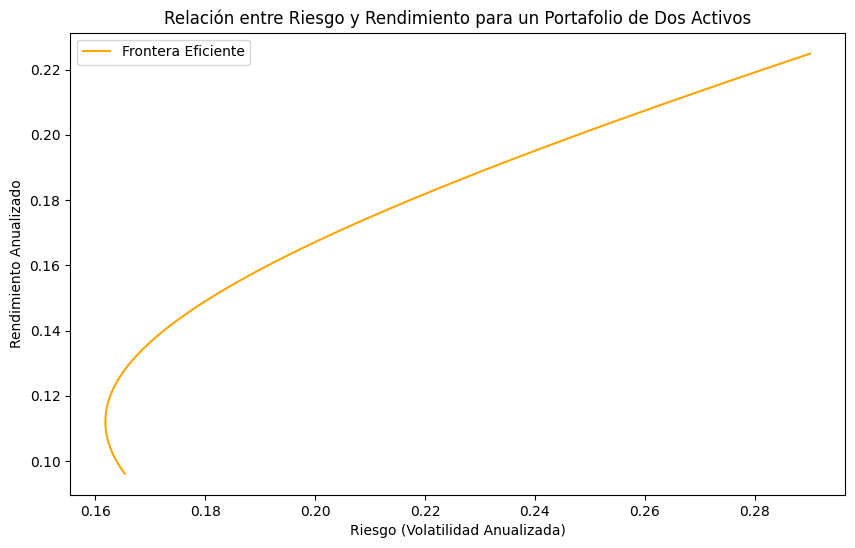

In [10]:
# Graficar la línea de la frontera eficiente para dos activos
plt.figure(figsize=(10, 6))
plt.plot(riesgos, rendimientos, label='Frontera Eficiente', color='orange')

# Etiquetas y título
plt.title("Relación entre Riesgo y Rendimiento para un Portafolio de Dos Activos")
plt.xlabel("Riesgo (Volatilidad Anualizada)")
plt.ylabel("Rendimiento Anualizado")
plt.legend(loc='upper left')

# Mostrar el gráfico
plt.show()

## **Volatilidad mínima (Varianza mínima)**
   - En lugar de maximizar un ratio de retorno-riesgo, busca minimizar la varianza del portafolio:
   $$
   \min_{\textbf{w}} \textbf{w}^\top \Sigma \textbf{w}
   $$
   Este enfoque es útil para construir portafolios con el menor riesgo posible, independientemente de los retornos esperados.

In [11]:
# Función objetivo: Minimizar la varianza del portafolio
def varianza_minima(w, cov):
    return np.dot(w.T, np.dot(cov, w))  # Varianza del portafolio

In [12]:
# Restricción: los pesos deben sumar 1
restricciones = (
    {"type": "eq", "fun": lambda w: np.sum(w) - 1}  # Pesos suman 1
)

In [13]:
# Límites: los pesos deben estar entre 0 y 1 (sin posiciones cortas)
limites = [(0, 1) for _ in range(len(covarianzas))]

In [14]:
# Pesos iniciales: distribución igualitaria
pesos_iniciales = np.array([1 / len(covarianzas_anualizada)] * len(covarianzas_anualizada))

In [15]:
# Optimización
resultado = minimize(
    varianza_minima,
    pesos_iniciales,
    args=(covarianzas_anualizada,),
    constraints=restricciones,
    bounds=limites,
    method="SLSQP"
)

In [16]:
# Pesos óptimos
pesos_minima_varianza  = resultado.x
# Mostrar los resultados
print("Pesos óptimos para el portafolio de mínima varianza:")
print(pesos_minima_varianza )

Pesos óptimos para el portafolio de mínima varianza:
[0.87626299 0.12373701]


In [17]:
rendimiento_minima_varianza = np.dot(pesos_minima_varianza, rendimiento_anualizado)
riesgo_minima_varianza = np.sqrt(np.dot(pesos_minima_varianza.T, np.dot(covarianzas_anualizada, pesos_minima_varianza)))

print(f"Rendimiento anualizado del portafolio de mínima varianza: {rendimiento_minima_varianza:.4f}")
print(f"Riesgo (volatilidad) anualizado del portafolio de mínima varianza: {riesgo_minima_varianza:.4f}")

Rendimiento anualizado del portafolio de mínima varianza: 0.1120
Riesgo (volatilidad) anualizado del portafolio de mínima varianza: 0.1618


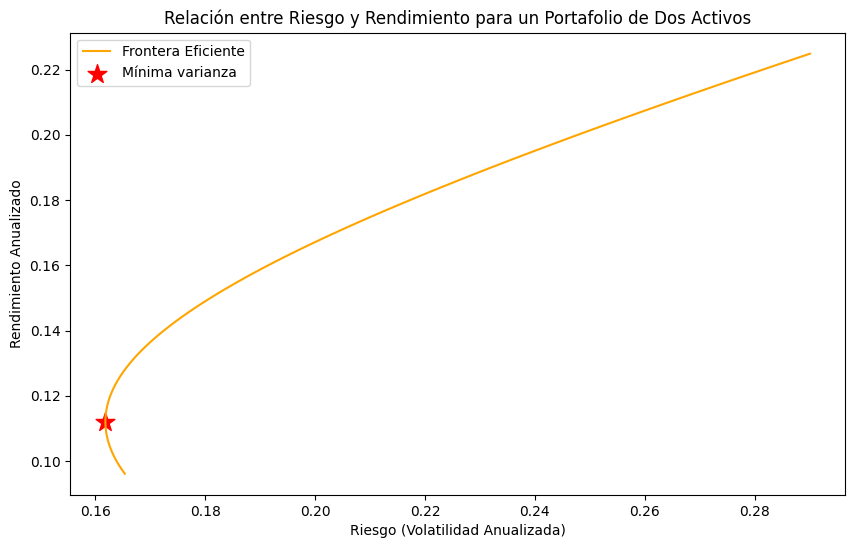

In [18]:
# Graficar la línea de la frontera eficiente para dos activos
plt.figure(figsize=(10, 6))
plt.plot(riesgos, rendimientos, label='Frontera Eficiente', color='orange')

# Graficar el portafolio de mínima varianza
plt.scatter(riesgo_minima_varianza, rendimiento_minima_varianza, color='red', marker='*', s=200, label='Mínima varianza')

# Etiquetas y título
plt.title("Relación entre Riesgo y Rendimiento para un Portafolio de Dos Activos")
plt.xlabel("Riesgo (Volatilidad Anualizada)")
plt.ylabel("Rendimiento Anualizado")
plt.legend(loc='upper left')

# Mostrar el gráfico
plt.show()

## **Asimetria y curtosis**

El criterio de **asimetría** y **curtosis** se define mediante las siguientes fórmulas:

1. **Asimetría ($S$)**:  
   $$
   S = \frac{E\big[(R_p - \mu_p)^3\big]}{\sigma_p^3}
   $$  
   - Mide la simetría de los retornos del portafolio ($R_p$).  
   - Valores positivos indican mayor probabilidad de retornos elevados.  

2. **Curtosis ($K$)**:  
   $$
   K = \frac{E\big[(R_p - \mu_p)^4\big]}{\sigma_p^4}
   $$  
   - Mide la concentración de eventos extremos en los retornos.  
   - Valores altos indican mayor riesgo de caídas severas o picos extremos.

El criterio busca **maximizar la asimetría** y **minimizar la curtosis**, balanceando oportunidades de altos retornos y controlando riesgos extremos.

In [19]:
# Calcular asimetría y curtosis de un portafolio dado sus pesos
def calcular_asimetria(y, pesos):
    portafolio_retornos = np.dot(y, pesos)
    return np.mean((portafolio_retornos - np.mean(portafolio_retornos))**3) / np.std(portafolio_retornos)**3

In [20]:
def calcular_curtosis(y, pesos):
    portafolio_retornos = np.dot(y, pesos)
    return np.mean((portafolio_retornos - np.mean(portafolio_retornos))**4) / np.std(portafolio_retornos)**4

In [21]:
# Definir la función objetivo para maximizar la asimetría y minimizar la curtosis
def objetivo(w, y, lambda_asimetria=1.0, lambda_curtosis=1.0):
    asimetria = calcular_asimetria(y, w)
    curtosis = calcular_curtosis(y, w)
    return -lambda_asimetria * asimetria + lambda_curtosis * curtosis

In [22]:
# Restricción: la suma de los pesos debe ser 1
def restriccion_suma_pesos(w):
    return np.sum(w) - 1

In [23]:
# Restricción: los pesos deben ser positivos
def restriccion_pesos_positivos(w):
    return w

In [24]:
retornos_diarios = datos.pct_change().dropna()
y = retornos_diarios.values

# Optimización
resultado = minimize(
    objetivo,
    pesos_iniciales,
    args=(y,),
    method='SLSQP',
    bounds=limites,
    constraints=restricciones
)

# Resultado
pesos_asimetria = resultado.x
print("Pesos óptimos para el criterio de asimetría y curtosis:")
print(pesos_asimetria)

Pesos óptimos para el criterio de asimetría y curtosis:
[0.18536251 0.81463749]


In [25]:
rendimiento_asimetria = np.dot(pesos_asimetria, rendimiento_anualizado)
riesgo_asimetria = np.sqrt(np.dot(pesos_asimetria.T, np.dot(covarianzas_anualizada, pesos_asimetria)))

print(f"Rendimiento anualizado del portafolio de mínima varianza: {rendimiento_asimetria:.4f}")
print(f"Riesgo (volatilidad) anualizado del portafolio de mínima varianza: {riesgo_asimetria:.4f}")

Rendimiento anualizado del portafolio de mínima varianza: 0.2010
Riesgo (volatilidad) anualizado del portafolio de mínima varianza: 0.2494


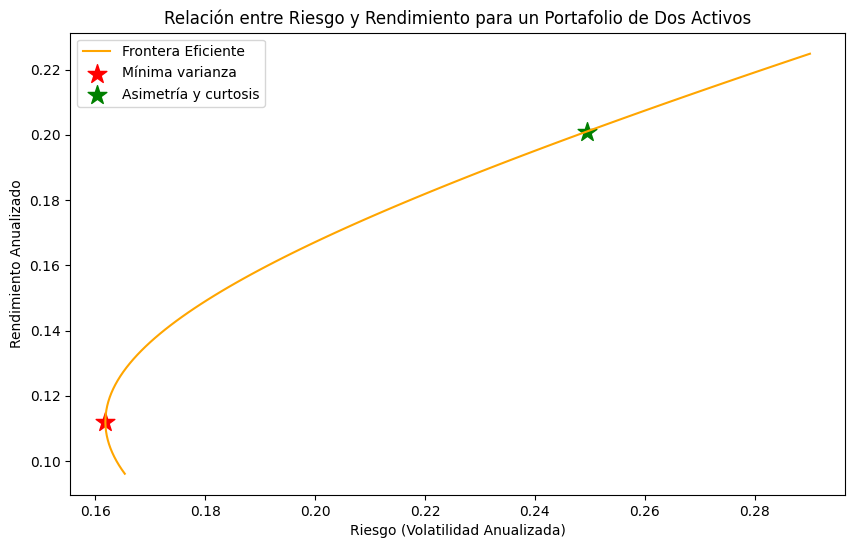

In [26]:
# Graficar la línea de la frontera eficiente para dos activos
plt.figure(figsize=(10, 6))
plt.plot(riesgos, rendimientos, label='Frontera Eficiente', color='orange')

plt.scatter(riesgo_minima_varianza, rendimiento_minima_varianza, color='red', marker='*', s=200, label='Mínima varianza')
plt.scatter(riesgo_asimetria, rendimiento_asimetria, color='green', marker='*', s=200, label='Asimetría y curtosis')

# Etiquetas y título
plt.title("Relación entre Riesgo y Rendimiento para un Portafolio de Dos Activos")
plt.xlabel("Riesgo (Volatilidad Anualizada)")
plt.ylabel("Rendimiento Anualizado")
plt.legend(loc='upper left')

# Mostrar el gráfico
plt.show()

## **Ratio Sharpe**

El ratio de Sharpe puede guiar la selección de pesos en un portafolio. La idea es maximizar este indicador ajustando los pesos de los activos de forma que el portafolio tenga el mayor retorno posible por unidad de riesgo. Esto se logra mediante optimización, típicamente resolviendo un problema como:


\max_{\textbf{w}} \frac{\textbf{w}^\top \mu - R_f}{\sqrt{\textbf{w}^\top \Sigma \textbf{w}}}
$$

Donde:
- $\textbf{w}$: Vector de pesos del portafolio.
- $\mu$: Vector de retornos esperados de los activos.
- $\Sigma$: Matriz de covarianzas de los retornos de los activos.

In [27]:
# Tasa libre de riesgo anualizada (suponemos que es 3.3%)
tasa_libre_riesgo = 0.033

# Función para calcular el rendimiento y riesgo del portafolio
def rendimiento_riesgo(pesos, retornos, covarianzas):
    rendimiento = np.dot(pesos, retornos)
    riesgo = np.sqrt(np.dot(pesos.T, np.dot(covarianzas, pesos)))
    return rendimiento, riesgo

# Función objetivo: Maximizar el ratio de Sharpe
def ratio_sharpe(pesos, retornos, covarianzas, tasa_libre_riesgo):
    rendimiento, riesgo = rendimiento_riesgo(pesos, retornos, covarianzas)
    return -(rendimiento - tasa_libre_riesgo) / riesgo  # Negamos para minimizar

In [28]:
# Restricción: los pesos deben sumar 1
restricciones = (
    {"type": "eq", "fun": lambda w: np.sum(w) - 1}  # Pesos suman 1
)

In [29]:
# Límites: los pesos deben estar entre 0 y 1 (sin posiciones cortas)
limites = [(0, 1) for _ in range(len(covarianzas))]

In [30]:
# Pesos iniciales: distribución igualitaria
pesos_iniciales = np.array([1 / len(covarianzas)] * len(covarianzas))

In [31]:
# Optimización
resultado = minimize(
    ratio_sharpe,
    pesos_iniciales,
    args=(rendimiento_anualizado, covarianzas_anualizada, tasa_libre_riesgo),
    constraints=restricciones,
    bounds=limites,
    method="SLSQP"
)

In [32]:
# Pesos óptimos
pesos_optimos_sharpe = resultado.x

In [33]:
# Mostrar los resultados
rendimiento_sharpe, riesgo_sharpe = rendimiento_riesgo(pesos_optimos_sharpe, rendimiento_anualizado, covarianzas_anualizada)
print(f"Pesos óptimos (según ratio de Sharpe): {pesos_optimos_sharpe}")
print(f"Rendimiento anualizado del portafolio óptimo: {rendimiento_sharpe:.4f}")
print(f"Riesgo anualizado del portafolio óptimo: {riesgo_sharpe:.4f}")

Pesos óptimos (según ratio de Sharpe): [0.31176643 0.68823357]
Rendimiento anualizado del portafolio óptimo: 0.1847
Riesgo anualizado del portafolio óptimo: 0.2241


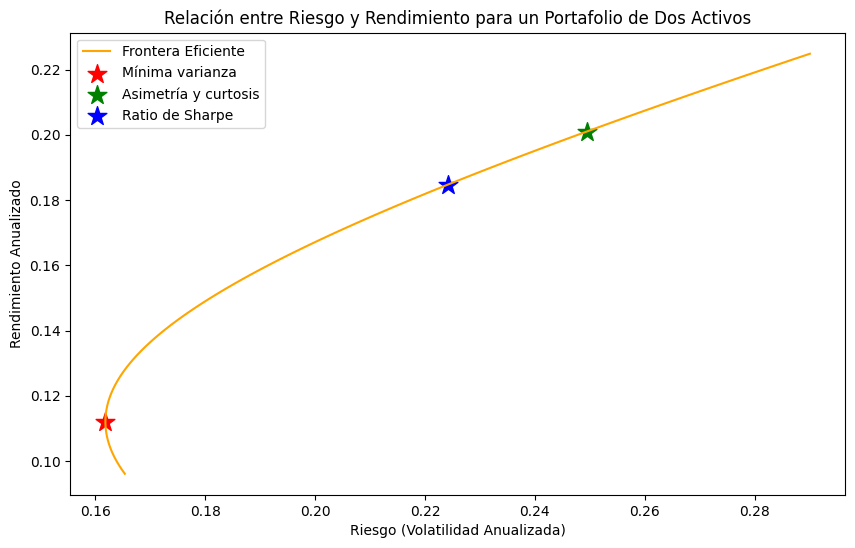

In [34]:
# Graficar la línea de la frontera eficiente para dos activos
plt.figure(figsize=(10, 6))
plt.plot(riesgos, rendimientos, label='Frontera Eficiente', color='orange')

# Graficar el portafolio de mínima varianza
plt.scatter(riesgo_minima_varianza, rendimiento_minima_varianza, color='red', marker='*', s=200, label='Mínima varianza')
plt.scatter(riesgo_asimetria, rendimiento_asimetria, color='green', marker='*', s=200, label='Asimetría y curtosis')

# Graficar el portafolio de Sharpe
plt.scatter(riesgo_sharpe, rendimiento_sharpe, color='blue', marker='*', s=200, label='Ratio de Sharpe')

# Etiquetas y título
plt.title("Relación entre Riesgo y Rendimiento para un Portafolio de Dos Activos")
plt.xlabel("Riesgo (Volatilidad Anualizada)")
plt.ylabel("Rendimiento Anualizado")
plt.legend(loc='upper left')

# Mostrar el gráfico
plt.show()

## **Ratio de Sortino**
   - Similar al ratio de Sharpe, pero se enfoca en la **desviación negativa** en lugar de la desviación estándar total. Esto permite medir solo los riesgos "indeseables".
   $$
   \text{Sortino Ratio} = \frac{R_p - R_f}{\sigma_{\text{negativa}}}
   $$
   Donde $\sigma_{\text{negativa}}$ es la desviación estándar de los retornos que están por debajo de un umbral (generalmente $R_f$).

In [35]:
# Función para calcular el rendimiento anualizado del portafolio
def f_rendimiento_anualizado(pesos, retornos):
    return np.dot(pesos, retornos.mean()) * 252  # Rendimiento anualizado

# Función para calcular el downside risk (riesgo negativo)
def downside_risk(pesos, retornos):
    # Calcular los rendimientos del portafolio
    rendimientos_portafolio = np.dot(retornos, pesos)

    # Calcular los rendimientos negativos
    downside = rendimientos_portafolio[rendimientos_portafolio < 0]  # Solo los rendimientos negativos
    if len(downside) == 0:  # Si no hay rendimientos negativos
        return 0  # Consideramos que el downside risk es 0 si no hay pérdidas
    downside_deviation = np.std(downside)  # Desviación estándar de los rendimientos negativos
    return downside_deviation

# Función objetivo: Maximizar el ratio de Sortino (rendimiento / downside risk)
def ratio_sortino(pesos, retornos, tasa_libre_riesgo):
    rendimiento = f_rendimiento_anualizado(pesos, retornos)
    downside = downside_risk(pesos, retornos)
    if downside == 0:  # Evitar división por cero
        return np.inf  # Penalizar la solución si el riesgo negativo es 0
    return -(rendimiento - tasa_libre_riesgo) / downside  # Negar para minimizar

In [36]:
# Restricción: los pesos deben sumar 1
restricciones = (
    {"type": "eq", "fun": lambda w: np.sum(w) - 1}  # Pesos suman 1
)

In [37]:
# Límites: los pesos deben estar entre 0 y 1 (sin posiciones cortas)
limites = [(0, 1) for _ in range(len(covarianzas))]

In [38]:
# Pesos iniciales: distribución igualitaria
pesos_iniciales = np.array([1 / len(covarianzas)] * len(covarianzas))

In [39]:
tasa_libre_riesgo

0.033

In [40]:
# Optimización para maximizar el ratio de Sortino
resultado = minimize(
    ratio_sortino,
    pesos_iniciales,
    args=(retornos_diarios, tasa_libre_riesgo),  # Asumiendo tasa libre de riesgo = 0
    constraints=restricciones,
    bounds=limites,
    method="SLSQP"
)

In [41]:
# Pesos óptimos según el ratio de Sortino
pesos_optimos_sortino = resultado.x
pesos_optimos_sortino

array([0.27135842, 0.72864158])

In [42]:
covarianzas

Ticker,KO,MSFT
Ticker,,
KO,0.000108,0.000071
MSFT,0.000071,0.000334


In [43]:
# Calcular el rendimiento y riesgo con los pesos óptimos de Sortino
rendimiento_sortino, riesgo_sortino = rendimiento_riesgo(pesos_optimos_sortino, rendimiento_anualizado, covarianzas_anualizada)

In [44]:
pesos_optimos_sharpe

array([0.31176643, 0.68823357])

In [45]:
pesos_optimos_sortino

array([0.27135842, 0.72864158])

In [46]:
# Mostrar los resultados
print(f"Pesos óptimos (según ratio de Sortino): {pesos_optimos_sortino}")
print(f"Rendimiento anualizado del portafolio óptimo: {rendimiento_sortino:.4f}")
print(f"Riesgo anualizado (volatilidad) del portafolio óptimo: {riesgo_sortino:.4f}")

Pesos óptimos (según ratio de Sortino): [0.27135842 0.72864158]
Rendimiento anualizado del portafolio óptimo: 0.1899
Riesgo anualizado (volatilidad) del portafolio óptimo: 0.2320


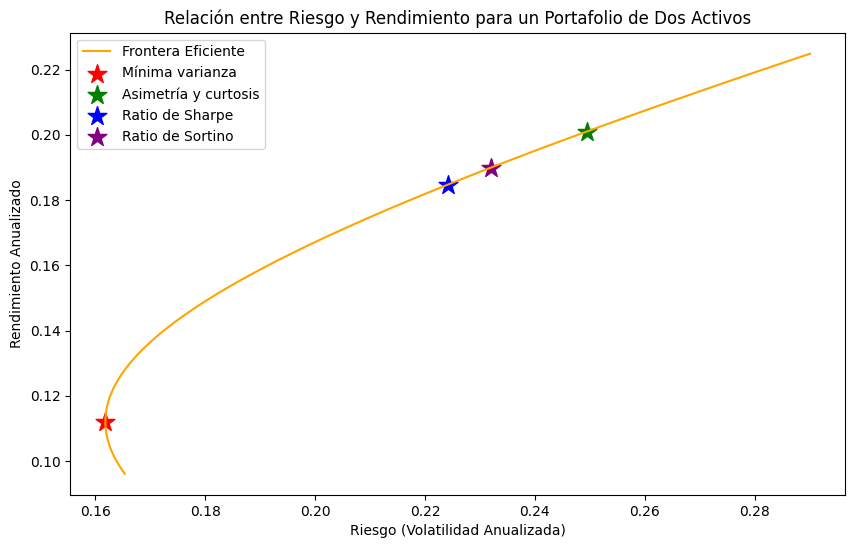

In [47]:
# Graficar la línea de la frontera eficiente para dos activos
plt.figure(figsize=(10, 6))
plt.plot(riesgos, rendimientos, label='Frontera Eficiente', color='orange')

# Graficar el portafolio de mínima varianza
plt.scatter(riesgo_minima_varianza, rendimiento_minima_varianza, color='red', marker='*', s=200, label='Mínima varianza')
plt.scatter(riesgo_asimetria, rendimiento_asimetria, color='green', marker='*', s=200, label='Asimetría y curtosis')

# Graficar el portafolio de Sharpe
plt.scatter(riesgo_sharpe, rendimiento_sharpe, color='blue', marker='*', s=200, label='Ratio de Sharpe')

# Graficar el portafolio de Sortino
plt.scatter(riesgo_sortino, rendimiento_sortino, color='purple', marker='*', s=200, label='Ratio de Sortino')

# Etiquetas y título
plt.title("Relación entre Riesgo y Rendimiento para un Portafolio de Dos Activos")
plt.xlabel("Riesgo (Volatilidad Anualizada)")
plt.ylabel("Rendimiento Anualizado")
plt.legend(loc='upper left')

# Mostrar el gráfico
plt.show()

## Ratio de Treynor

In [48]:
mercado = yf.download('^GSPC', start='2021-01-01', end='2023-06-30')
mercado = mercado['Adj Close'].pct_change().dropna()

[*********************100%***********************]  1 of 1 completed


In [49]:
def rendimiento_portafolio(w, rendimientos):
    return rendimientos.dropna().dot(w)

In [50]:
def calcular_beta(rendimiento_activo, rendimiento_mercado):
    X = sm.add_constant(rendimiento_mercado.iloc[:,0])  # Añadir el término constante
    modelo = sm.OLS(rendimiento_activo, X).fit()  # Regresión lineal
    beta = modelo.params.iloc[1]  # El coeficiente de la variable independiente es el beta
    return beta

In [51]:
def treynor_ratio(w, rendimientos, Rf, mercado):
    rp = np.mean(rendimiento_portafolio(w, rendimientos))
    bp = calcular_beta(rendimiento_portafolio(w, rendimientos), mercado)
    #Rf = (1 + Rf) ** (1 / 252) - 1
    rp = (1 + rp) ** (252) - 1
    #print(f"({rp:.4f}-{Rf})/{bp:.4f}")
    treynor = (rp - Rf) / bp
    return -treynor  # Negativo para minimizar

In [52]:
treynor_ratio([0.5,0.5], retornos_diarios, tasa_libre_riesgo, mercado)

-0.16304752795060584

In [53]:
# Restricción: los pesos deben sumar 1
def restriccion_suma_pesos(w):
    return np.sum(w) - 1

# Valores iniciales
tam = len(empresas)
w0 = np.random.random(tam)
w0 = w0 / np.sum(w0)

# Optimización
restricciones = [
    {'type': 'eq', 'fun': restriccion_suma_pesos}
]

In [54]:
# Resolver el problema
resultado = minimize(
    treynor_ratio,
    w0,
    args=(retornos_diarios, tasa_libre_riesgo, mercado),
    constraints=restricciones,
    bounds=[(0, 1) for _ in range(tam)]  # Pesos en [0, 1]
)

In [55]:
resultado

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.17439798806788775
       x: [ 0.000e+00  1.000e+00]
     nit: 4
     jac: [-2.991e-02 -4.957e-02]
    nfev: 12
    njev: 4

In [56]:
# Pesos óptimos
pesos_optimos_treynor = resultado.x

# Mostrar resultados
print("Pesos óptimos:", pesos_optimos_treynor)

# Calcular el Ratio de Treynor óptimo
treynor_optimo = -resultado.fun
print("Ratio de Treynor óptimo:", treynor_optimo)

Pesos óptimos: [0. 1.]
Ratio de Treynor óptimo: 0.17439798806788775


In [57]:
rendimiento_treynor, riesgo_treynor = rendimiento_riesgo(pesos_optimos_treynor, rendimiento_anualizado, covarianzas_anualizada)

In [58]:
# Mostrar los resultados
print(f"Pesos óptimos (según ratio de treynor): {pesos_optimos_treynor}")
print(f"Rendimiento anualizado del portafolio óptimo: {rendimiento_treynor:.4f}")
print(f"Riesgo anualizado (volatilidad) del portafolio óptimo: {riesgo_treynor:.4f}")

Pesos óptimos (según ratio de treynor): [0. 1.]
Rendimiento anualizado del portafolio óptimo: 0.2249
Riesgo anualizado (volatilidad) del portafolio óptimo: 0.2901


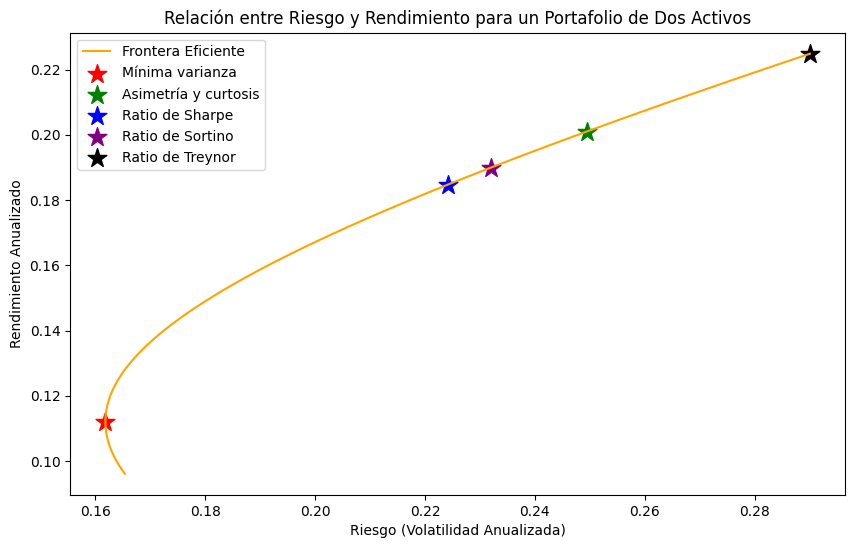

In [59]:
# Graficar la línea de la frontera eficiente para dos activos
plt.figure(figsize=(10, 6))
plt.plot(riesgos, rendimientos, label='Frontera Eficiente', color='orange')

# Graficar el portafolio de mínima varianza
plt.scatter(riesgo_minima_varianza, rendimiento_minima_varianza, color='red', marker='*', s=200, label='Mínima varianza')
plt.scatter(riesgo_asimetria, rendimiento_asimetria, color='green', marker='*', s=200, label='Asimetría y curtosis')

# Graficar el portafolio de Sharpe
plt.scatter(riesgo_sharpe, rendimiento_sharpe, color='blue', marker='*', s=200, label='Ratio de Sharpe')

# Graficar el portafolio de Sortino
plt.scatter(riesgo_sortino, rendimiento_sortino, color='purple', marker='*', s=200, label='Ratio de Sortino')

# Graficar el portafolio de Treynor
plt.scatter(riesgo_treynor, rendimiento_treynor, color='black', marker='*', s=200, label='Ratio de Treynor')

# Etiquetas y título
plt.title("Relación entre Riesgo y Rendimiento para un Portafolio de Dos Activos")
plt.xlabel("Riesgo (Volatilidad Anualizada)")
plt.ylabel("Rendimiento Anualizado")
plt.legend(loc='upper left')

# Mostrar el gráfico
plt.show()

## Comparando Portafolios

In [60]:
datos2 = yf.download(empresas, start='2023-06-30', end='2023-12-31')['Adj Close']
datos2.head()

[*********************100%***********************]  2 of 2 completed


Ticker,KO,MSFT
Date,,
2023-06-30,57.953587,337.288818
2023-07-03,58.300037,334.763153
2023-07-05,58.733105,334.921631
2023-07-06,58.280796,338.011810
2023-07-07,57.510895,334.000488


In [61]:
test = pd.DataFrame()
test['Minima_varianza'] = datos2.pct_change().dot(pesos_minima_varianza)
test['Asimetria'] = datos2.pct_change().dot(pesos_asimetria)
test['Ratio sharpe'] = datos2.pct_change().dot(pesos_optimos_sharpe)
test['Ratio Sortino'] = datos2.pct_change().dot(pesos_optimos_sortino)
test['Ratio Treynor'] = datos2.pct_change().dot(pesos_optimos_treynor)
test = test.dropna()
test.head()

,Minima_varianza,Asimetria,Ratio sharpe,Ratio Sortino,Ratio Treynor
Date,,,,,
2023-07-03,0.004312,-0.004992,-0.003290,-0.003834,-0.007488
2023-07-05,0.006568,0.001763,0.002642,0.002361,0.000473
2023-07-06,-0.005607,0.006089,0.003949,0.004633,0.009227
2023-07-07,-0.013044,-0.012116,-0.012286,-0.012232,-0.011867
2023-07-10,-0.008576,-0.014417,-0.013348,-0.013690,-0.015984


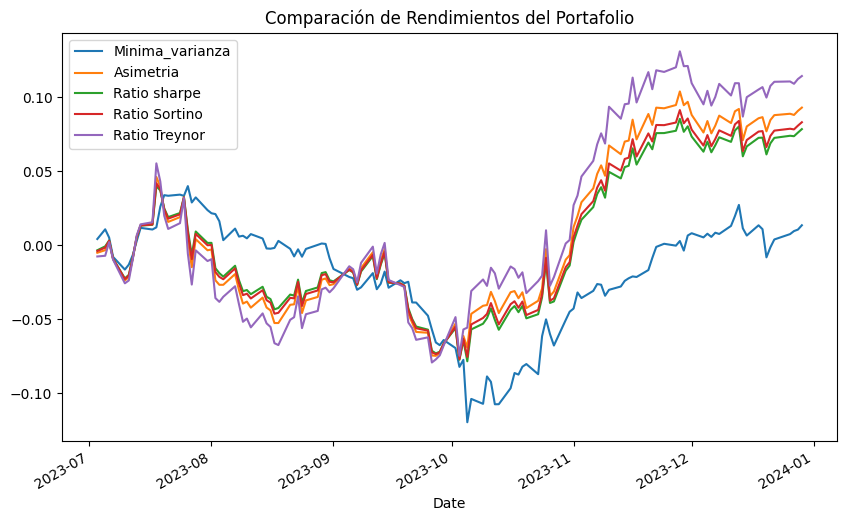

In [62]:
fig, ax = plt.subplots(figsize=(10,6))
test.cumsum().plot(ax=ax)
ax.set_title("Comparación de Rendimientos del Portafolio")
fig.show()